# Example Two: Animals-10

**In this example, I will do the following:**

    1. Build my own model and eval
    2. Use pretrained model and best weights possible and compare
    3. Choose the best model and plot the loss curves and confusion matrix

In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics

from typing import List, Dict, Tuple, Final
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy, ConfusionMatrix
from torch.utils.data import DataLoader
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

In [3]:
print(f'PyTorch Version: {torch.__version__}')
print(f'torchvision Version: {torchvision.__version__}')

PyTorch Version: 1.13.1
torchvision Version: 0.14.1


## 1. Data Preparation and Exploration

In [4]:
# instantiate tensorboard writer
writer = SummaryWriter()

In [5]:
# setting up the training and testing directory
train_dir = 'raw-img/train'
test_dir = 'raw-img/test'

In [6]:
# set up train and test transforms, using TrivialAugmentWide to transform train data for more accuracy
train_transform = transforms.Compose([
    transforms.Resize(size=(244, 244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(244, 244)),
    transforms.ToTensor()
])

In [7]:
# set up train and test data using ImageFolder
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform,
    target_transform=None
)

In [8]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 20882
     Root location: raw-img/train
     StandardTransform
 Transform: Compose(
                Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 5297
     Root location: raw-img/test
     StandardTransform
 Transform: Compose(
                Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [9]:
train_data.classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [10]:
train_data.classes == test_data.classes

True

In [11]:
class_names = train_data.classes

In [12]:
image, label = next(iter(train_data))

In [13]:
image.shape, class_names[label]

(torch.Size([3, 244, 244]), 'butterfly')

In [14]:
# make a function to preview an image
def preview_image(data: Tuple):
    plt.imshow(data[0].permute(1, 2, 0))
#     plt.axis(False)
    plt.xlabel(class_names[data[1]])
    plt.ylabel(data[0].shape)
    plt.show()

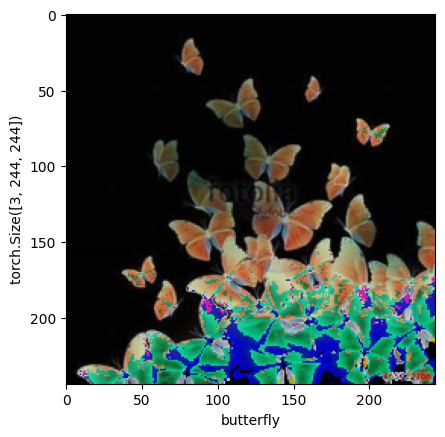

In [15]:
preview_image(train_data[0])

In [16]:
# set up dataloader
BATCH_SIZE : Final = 128
    
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=128,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=128,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [17]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x28dd6b310>,
 <torch.utils.data.dataloader.DataLoader at 0x28dd6b940>)

## 2. Building Baseline Model

In [18]:
class AnimalsBaselineModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 3 * 3,
                out_features=output_shape
            )
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))
    
    def __name__(self):
        return 'AnimalsBaselineModel'

In [19]:
model_0 = AnimalsBaselineModel(input_shape=3, output_shape=10, hidden_units=50)

In [20]:
model_0

AnimalsBaselineModel(
  (block1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=450, out_features=10, bias=True)
  )
)

In [19]:
dummy = torch.randn(size=(3, 244, 244))

In [21]:
# use a dummy data to detect any fault in the model
with torch.inference_mode():
    dummy_pred = model_0(dummy.unsqueeze(0))
torch.softmax(dummy_pred, dim=1).argmax(dim=1), dummy_pred.argmax(dim=1), class_names[dummy_pred.argmax(dim=1)]

(tensor([5]), tensor([5]), 'elephant')

## 2. Setup Train and Test Loop

In [20]:
def train_step(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    optim: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader
):
    train_loss, train_acc = 0, 0
    model.train()
    print('Starting training cycle:\n------------')
    
    for batch, (X, y) in enumerate(tqdm(dataloader)):
#         X, y = X.to('mps'), y.to('mps')
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss
        train_acc += accuracy_function(y_pred.argmax(dim=1), y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc*100

In [21]:
def test_step(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    dataloader: torch.utils.data.DataLoader
):
    test_loss, test_acc = 0, 0
    model.eval()
    print('Starting testing cycle:\n--------------')
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
#             X, y = X.to('mps'), y.to('mps')
            y_pred = model(X)
            test_loss += loss_function(y_pred, y)
            test_acc += accuracy_function(y_pred.argmax(dim=1), y)
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        
    return test_loss, test_acc*100

In [22]:
def train_model(
    model: nn.Module,
    loss_function: nn.Module,
    optim: torch.optim.Optimizer,
    accuracy_function,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5
) -> Dict:
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    for _ in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                  loss_function=loss_function,
                  optim=optim,
                  accuracy_function=accuracy_function,
                  dataloader=train_loader)
        
        test_loss, test_acc = test_step(model=model,
                 loss_function=loss_function,
                 accuracy_function=accuracy_function,
                 dataloader=test_loader)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
        
        results['train_loss'].append(float(train_loss.detach().numpy()))
        results['train_acc'].append(float(train_acc.detach().numpy()))
        results['test_loss'].append(float(test_loss.detach().numpy()))
        results['test_acc'].append(float(test_acc.detach().numpy()))
        
    return results

## 3. Train the Baseline Model 

In [24]:
model_0 = AnimalsBaselineModel(input_shape=3, output_shape=10, hidden_units=50)
model_0.load_state_dict(torch.load('BaseLineModel.pt'))

<All keys matched successfully>

In [25]:
# set up optimizer, loss function and accuracy function
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))

In [26]:
model_0_result = train_model(model=model_0,
                            loss_function=loss_fn,
                            accuracy_function=acc_fn,
                            optim=optimizer,
                            train_loader=train_dataloader,
                            test_loader=test_dataloader,
                            epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 2.1973 | Train Acc: 19.57% | Test Loss: 2.0912 | Test Acc: 26.13%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:05<?, ?it/s]

Train Loss: 1.9818 | Train Acc: 31.21% | Test Loss: 1.7323 | Test Acc: 39.23%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.7814 | Train Acc: 39.34% | Test Loss: 1.6007 | Test Acc: 45.05%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [02:44<?, ?it/s]

Train Loss: 1.6898 | Train Acc: 42.58% | Test Loss: 1.5767 | Test Acc: 44.68%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.6324 | Train Acc: 44.18% | Test Loss: 1.4950 | Test Acc: 47.36%


**Looks like the model is not really performing well enough, let's plot the loss curves.**

In [26]:
def plot_curves(result: Dict[str, List[float]]):
    
    trainloss = result['train_loss']
    trainacc = result['train_acc']    
    testloss = result['test_loss']
    testacc = result['test_acc']
    
    epochs = range(len(result['train_loss']))
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainloss, label='Train Loss')
    plt.plot(epochs, testloss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.title('Loss Curve')
    plt.ylim(0, 2.5)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainacc, label='Train Acc')
    plt.plot(epochs, testacc, label='Test Acc')
    plt.xlabel('Epoch')
    plt.title('Acc Curve')
    plt.ylim((0, 100))
    plt.legend()
    
    plt.show()

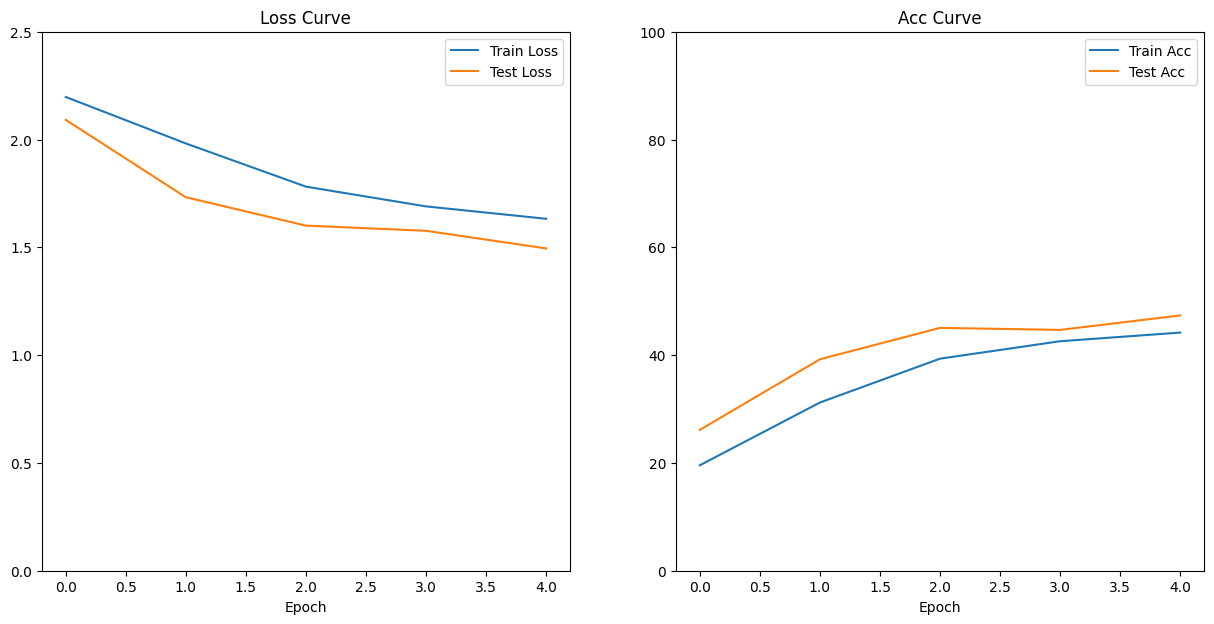

In [32]:
plot_curves(model_0_result)

**Looks like the model is not performing ideally due to severe underfitting. Let's see if we can tune the model for it to do better.**

In [27]:
# making a evaluate function
def eval_model(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    dataloader: torch.utils.data.DataLoader
):
    loss, acc = 0, 0
    model.eval()
    print(f'Evaluating...\n------------')
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            y_logit = model(X)
            y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
            loss += loss_function(y_logit, y)
            acc += accuracy_function(y_pred, y)
        
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {
        'Model Name': model.__class__.__name__,
        'Loss': float(loss.detach().numpy()),
        'Accuracy': float(acc.detach().numpy())*100
    }

In [34]:
model_0_eval = eval_model(model=model_0, loss_function=loss_fn, accuracy_function=acc_fn, dataloader=test_dataloader)
model_0_eval

Evaluating...
------------


  0%|          | 0/42 [00:05<?, ?it/s]

{'Model Name': 'AnimalsBaselineModel',
 'Loss': 1.494950532913208,
 'Accuracy': 47.36394286155701}

In [35]:
# saving the baseline model's state dict
torch.save(model_0.state_dict(), 'BaseLineModel.pt')

## 4. Improving Baseline Model

In [70]:
class AnimalsModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3*3,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))

In [71]:
model_1 = AnimalsModelV1(input_shape=3, output_shape=10, hidden_units=100)

In [72]:
model_1

AnimalsModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=900, out_features=10, bias=True)
  )
)

In [73]:
dummy.unsqueeze(0).shape

torch.Size([1, 3, 244, 244])

In [74]:
with torch.inference_mode():
    temp_pred = model_1(dummy.unsqueeze(0))

In [75]:
class_names[test_data[0][1]], class_names[temp_pred.argmax(dim=1)]

('butterfly', 'horse')

In [76]:
optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                              lr=0.0005)
model_1_result = train_model(model=model_1,
                            loss_function=loss_fn,
                            accuracy_function=acc_fn,
                            optim=optimizer_1,
                            train_loader=train_dataloader,
                            test_loader=test_dataloader,
                            epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 2.0181 | Train Acc: 28.58% | Test Loss: 1.7353 | Test Acc: 39.64%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.7279 | Train Acc: 41.25% | Test Loss: 1.5769 | Test Acc: 45.04%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.5601 | Train Acc: 47.36% | Test Loss: 1.3760 | Test Acc: 53.01%
Starting training cycle:
------------


  0%|          | 0/164 [02:45<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.4511 | Train Acc: 51.23% | Test Loss: 1.3009 | Test Acc: 54.91%
Starting training cycle:
------------


  0%|          | 0/164 [00:04<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/42 [00:04<?, ?it/s]

Train Loss: 1.3504 | Train Acc: 54.40% | Test Loss: 1.2072 | Test Acc: 59.36%


In [78]:
model_1_result

{'train_loss': [2.0181307792663574,
  1.7278920412063599,
  1.5600827932357788,
  1.451099157333374,
  1.3503742218017578],
 'train_acc': [28.57755470275879,
  41.25434112548828,
  47.361961364746094,
  51.22639465332031,
  54.396385192871094],
 'test_loss': [1.7353124618530273,
  1.5769320726394653,
  1.3760299682617188,
  1.3009315729141235,
  1.2071706056594849],
 'test_acc': [39.643314361572266,
  45.04411315917969,
  53.01263427734375,
  54.911094665527344,
  59.3609504699707]}

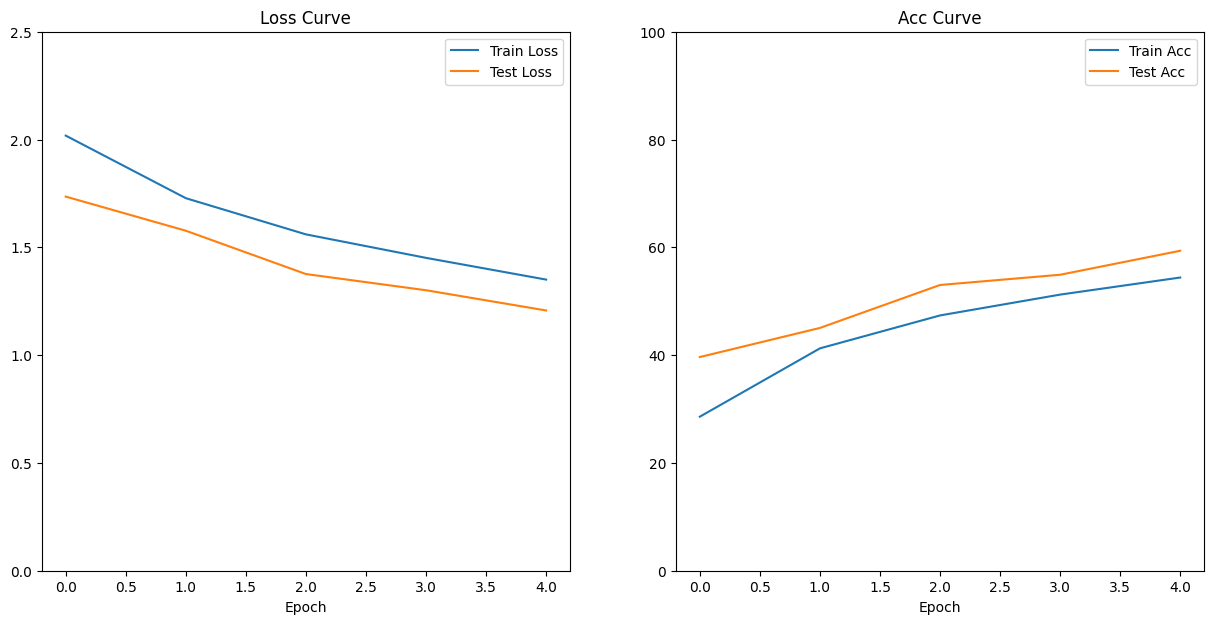

In [79]:
plot_curves(model_1_result)

In [80]:
model_1_eval = eval_model(model=model_1,
                         loss_function=loss_fn,
                         accuracy_function=acc_fn,
                         dataloader=test_dataloader)
model_1_eval

Evaluating...
------------


  0%|          | 0/42 [00:04<?, ?it/s]

{'Model Name': 'AnimalsModelV1',
 'Loss': 1.2071706056594849,
 'Accuracy': 59.36095118522644}

**Looks like the model is now better and can be improved even further if trained longer.**

## 5. Using Pre-trained Model

### ConvNext

In [86]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchinfo import summary

In [87]:
model_2 = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)

In [91]:
summary(model_2, row_settings=['var_names'])

Layer (type (var_name))                                 Param #
ConvNeXt (ConvNeXt)                                     --
├─Sequential (features)                                 --
│    └─Conv2dNormActivation (0)                         --
│    │    └─Conv2d (0)                                  (6,272)
│    │    └─LayerNorm2d (1)                             (256)
│    └─Sequential (1)                                   --
│    │    └─CNBlock (0)                                 (138,496)
│    │    └─CNBlock (1)                                 (138,496)
│    │    └─CNBlock (2)                                 (138,496)
│    └─Sequential (2)                                   --
│    │    └─LayerNorm2d (0)                             (256)
│    │    └─Conv2d (1)                                  (131,328)
│    └─Sequential (3)                                   --
│    │    └─CNBlock (0)                                 (539,136)
│    │    └─CNBlock (1)                                 (539,136

In [97]:
for params in model_2.features.parameters():
    params.requires_grad = False

In [98]:
model_2.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=10)
)

weights = ConvNeXt_Base_Weights.DEFAULT
auto_transform = weights.transforms()


In [99]:
test_data_pre = datasets.ImageFolder(
    root=test_dir,
    transform=auto_transform,
    target_transform=None
)

In [100]:
test_dataloader_pre = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [101]:
model_2_eval = eval_model(model=model_2,
                         loss_function=loss_fn,
                         accuracy_function=acc_fn,
                         dataloader=test_dataloader_pre)
model_2_eval

Evaluating...
------------


  0%|          | 0/42 [00:04<?, ?it/s]

{'Model Name': 'ConvNeXt',
 'Loss': 2.29766845703125,
 'Accuracy': 17.98735111951828}